<a href="https://colab.research.google.com/github/jokefun022/Real-Project-UET/blob/main/Copy_of_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab cell 1: install
!pip install -q scikit-learn gensim transformers torch tensorflow emoji matplotlib seaborn huggingface_hub joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
# Colab cell 2: imports
import os, gc, time, math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

# DL & embeddings
from gensim.models import Word2Vec, FastText
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Transformers
import torch
from transformers import AutoTokenizer, AutoModel

# Hugging Face
from huggingface_hub import HfApi, HfFolder, Repository, login

# Keras (for DL models)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("Torch:", torch.__version__, "TF:", tf.__version__)


Torch: 2.8.0+cu126 TF: 2.19.0


In [ ]:
DATA_PATH = "/content/Complete Data With Emoji.csv"  # path in Colab
df = pd.read_csv(DATA_PATH, encoding="utf-8")
# adjust column names here if necessary:
TEXT_COL = "Tweet_Text_With_Emoji"
LABEL_COL = "Label"

print("Rows:", len(df))
df.head()

Rows: 10672


,Tweet_Text_With_Emoji,Label,Sentiment Analysis
0,kah kay yih sach 😊 hai,0,Neutral
1,neither bhadwaa 😑 tantra rather madarjaat log ...,0,Neutral
2,kyoon okay yih kuchh logo ki 😃 fitrat hai,0,Neutral
3,lagta hsi man 🙌 chaaha job naey day rahay bhaa...,0,Neutral
4,achchha na bataao mujhay pata hai 😊,0,Neutral


In [ ]:
# Label encode
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df[LABEL_COL].astype(str))
num_classes = len(le.classes_)
print("Classes:", le.classes_, "Num:", num_classes)

Classes: ['0' '1' '2' '3' '4'] Num: 5


In [ ]:
RND = 42
X = df[TEXT_COL].astype(str).tolist()
y = df['label_enc'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RND, stratify=y)
print("Train:", len(X_train), "Test:", len(X_test))


Train: 8537 Test: 2135


In [ ]:
# 3A: TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

# 3B: Word2Vec (train on full texts tokenized)
sentences = [s.split() for s in X]  # simple whitespace tokenization; adapt if you have better tokenizer
w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=10)
wv_dim = w2v.wv.vector_size

def avg_w2v_features(texts, model=w2v, dim=wv_dim):
    fv = []
    for t in texts:
        words = t.split()
        vecs = [model.wv[w] for w in words if w in model.wv]
        if vecs:
            fv.append(np.mean(vecs, axis=0))
        else:
            fv.append(np.zeros(dim))
    return np.vstack(fv)

X_train_w2v = avg_w2v_features(X_train)
X_test_w2v  = avg_w2v_features(X_test)
print("W2V shapes:", X_train_w2v.shape, X_test_w2v.shape)

# 3C: FastText
ft = FastText(sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=10)
ft_dim = ft.wv.vector_size

def avg_ft_features(texts, model=ft, dim=ft_dim):
    fv = []
    for t in texts:
        words = t.split()
        vecs = [model.wv[w] for w in words if w in model.wv]
        if vecs:
            fv.append(np.mean(vecs, axis=0))
        else:
            fv.append(np.zeros(dim))
    return np.vstack(fv)

X_train_ft = avg_ft_features(X_train)
X_test_ft = avg_ft_features(X_test)
print("FastText shapes:", X_train_ft.shape, X_test_ft.shape)

# 3D: Emoji2Vec - simple approach: extract only emojis and run char ngram TF-IDF on emoji strings
import re
EMOJI_PATTERN = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags=re.UNICODE)

def extract_emojis(text):
    ems = EMOJI_PATTERN.findall(text)
    return " ".join(ems) if ems else ""

X_train_emoji = [extract_emojis(t) for t in X_train]
X_test_emoji  = [extract_emojis(t) for t in X_test]

# If no emojis in some rows, they will be empty strings; use char-level TF-IDF
emoji_vec = TfidfVectorizer(analyzer='char', ngram_range=(1,3), min_df=1)
X_train_emoji_tf = emoji_vec.fit_transform(X_train_emoji)
X_test_emoji_tf  = emoji_vec.transform(X_test_emoji)
print("Emoji TF shapes:", X_train_emoji_tf.shape, X_test_emoji_tf.shape)

# 3E: BERT (XLM-R) CLS embeddings (batched)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
bert = AutoModel.from_pretrained("xlm-roberta-base").to(device)
bert.eval()

def get_bert_cls(texts, batch_size=16):
    emb = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            out = bert(**enc)
        cls = out.last_hidden_state[:,0,:].cpu().numpy()
        emb.append(cls)
    return np.vstack(emb)

# Be careful: this can take time and memory for large datasets. We'll compute full if feasible.
print("Computing BERT embeddings for train & test (this may take some time)...")
X_train_bert = get_bert_cls(X_train, batch_size=16)
X_test_bert  = get_bert_cls(X_test, batch_size=16)
print("BERT shapes:", X_train_bert.shape, X_test_bert.shape)


TF-IDF shapes: (8537, 5000) (2135, 5000)
W2V shapes: (8537, 100) (2135, 100)
FastText shapes: (8537, 100) (2135, 100)
Emoji TF shapes: (8537, 114) (2135, 114)
Using device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Computing BERT embeddings for train & test (this may take some time)...
BERT shapes: (8537, 768) (2135, 768)


In [ ]:
import itertools
def eval_and_report(name, y_true, y_pred, labels_list=None, output_prefix=None):
    acc = accuracy_score(y_true, y_pred)
    prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print(f"\n{name} | Acc: {acc:.4f} | Prec(macro): {prec_macro:.4f} | Rec(macro): {rec_macro:.4f} | F1(macro): {f1_macro:.4f}")
    print(classification_report(y_true, y_pred, target_names=labels_list if labels_list is not None else le.classes_))
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=(labels_list if labels_list else le.classes_), yticklabels=(labels_list if labels_list else le.classes_))
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix: {name}")
    if output_prefix:
        plt.savefig(f"{output_prefix}_confusion.png", bbox_inches='tight')
    plt.show()
    return {"accuracy": acc, "precision_macro": prec_macro, "recall_macro": rec_macro, "f1_macro": f1_macro}




==== FEATURE: TFIDF ====

>> Model: LogisticRegression

LogisticRegression + TFIDF | Acc: 0.9419 | Prec(macro): 0.9013 | Rec(macro): 0.9104 | F1(macro): 0.9050
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1211
           1       0.84      0.86      0.85       145
           2       0.97      0.89      0.92       628
           3       0.89      0.88      0.88        80
           4       0.86      0.94      0.90        71

    accuracy                           0.94      2135
   macro avg       0.90      0.91      0.91      2135
weighted avg       0.94      0.94      0.94      2135



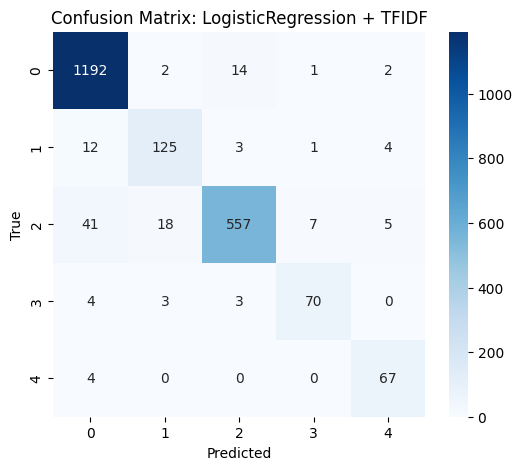

Error training LogisticRegression TFIDF -> [Errno 2] No such file or directory: 'models/LogisticRegression_TFIDF.joblib'

>> Model: SVM

SVM + TFIDF | Acc: 0.9630 | Prec(macro): 0.9551 | Rec(macro): 0.9218 | F1(macro): 0.9373
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1211
           1       0.93      0.83      0.88       145
           2       0.98      0.94      0.96       628
           3       0.99      0.90      0.94        80
           4       0.92      0.94      0.93        71

    accuracy                           0.96      2135
   macro avg       0.96      0.92      0.94      2135
weighted avg       0.96      0.96      0.96      2135



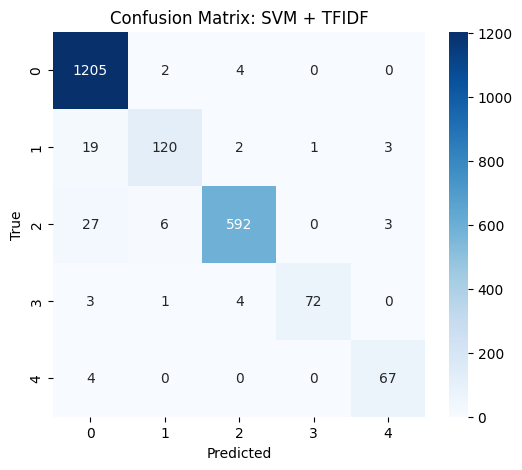

Error training SVM TFIDF -> [Errno 2] No such file or directory: 'models/SVM_TFIDF.joblib'

>> Model: RandomForest

RandomForest + TFIDF | Acc: 0.9621 | Prec(macro): 0.9401 | Rec(macro): 0.9217 | F1(macro): 0.9299
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1211
           1       0.89      0.88      0.88       145
           2       0.98      0.93      0.95       628
           3       0.96      0.85      0.90        80
           4       0.91      0.96      0.93        71

    accuracy                           0.96      2135
   macro avg       0.94      0.92      0.93      2135
weighted avg       0.96      0.96      0.96      2135



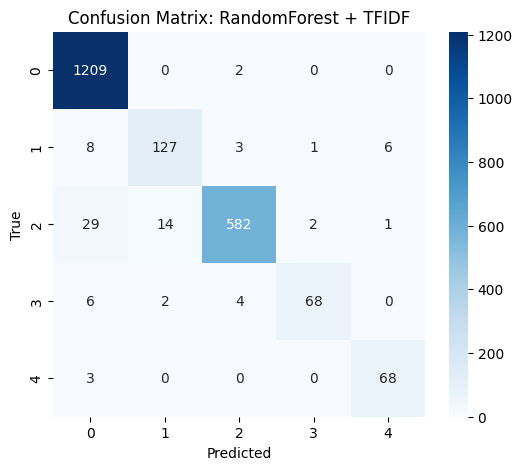

Error training RandomForest TFIDF -> [Errno 2] No such file or directory: 'models/RandomForest_TFIDF.joblib'

>> Model: DecisionTree

DecisionTree + TFIDF | Acc: 0.9625 | Prec(macro): 0.8957 | Rec(macro): 0.9285 | F1(macro): 0.9108
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1211
           1       0.85      0.85      0.85       145
           2       0.97      0.95      0.96       628
           3       0.84      0.89      0.86        80
           4       0.83      0.97      0.90        71

    accuracy                           0.96      2135
   macro avg       0.90      0.93      0.91      2135
weighted avg       0.96      0.96      0.96      2135



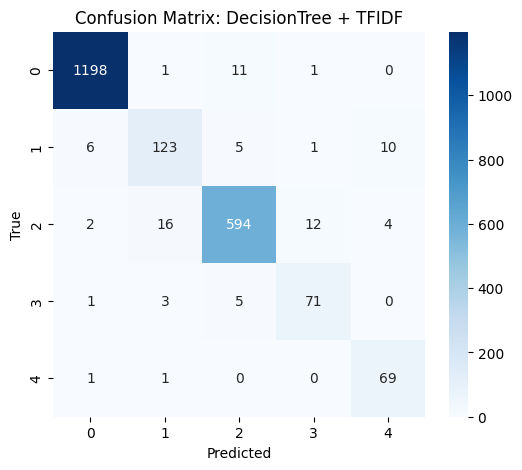

Error training DecisionTree TFIDF -> [Errno 2] No such file or directory: 'models/DecisionTree_TFIDF.joblib'

>> Model: GradientBoosting

GradientBoosting + TFIDF | Acc: 0.9489 | Prec(macro): 0.9080 | Rec(macro): 0.9265 | F1(macro): 0.9154
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1211
           1       0.86      0.85      0.85       145
           2       0.99      0.87      0.93       628
           3       0.86      0.93      0.89        80
           4       0.88      0.99      0.93        71

    accuracy                           0.95      2135
   macro avg       0.91      0.93      0.92      2135
weighted avg       0.95      0.95      0.95      2135



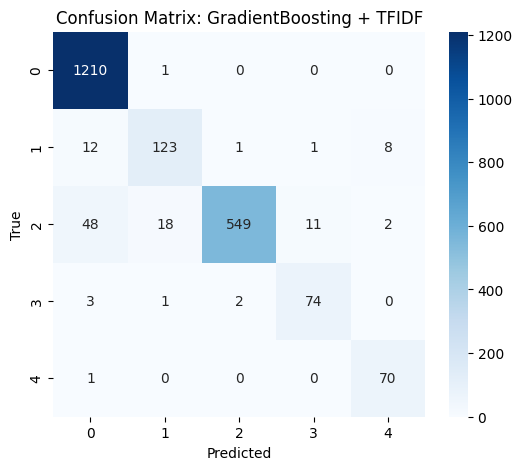

Error training GradientBoosting TFIDF -> [Errno 2] No such file or directory: 'models/GradientBoosting_TFIDF.joblib'

>> Model: NaiveBayes

NaiveBayes + TFIDF | Acc: 0.8197 | Prec(macro): 0.8674 | Rec(macro): 0.4921 | F1(macro): 0.5533
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1211
           1       0.81      0.26      0.40       145
           2       0.83      0.78      0.80       628
           3       1.00      0.11      0.20        80
           4       0.88      0.32      0.47        71

    accuracy                           0.82      2135
   macro avg       0.87      0.49      0.55      2135
weighted avg       0.83      0.82      0.79      2135



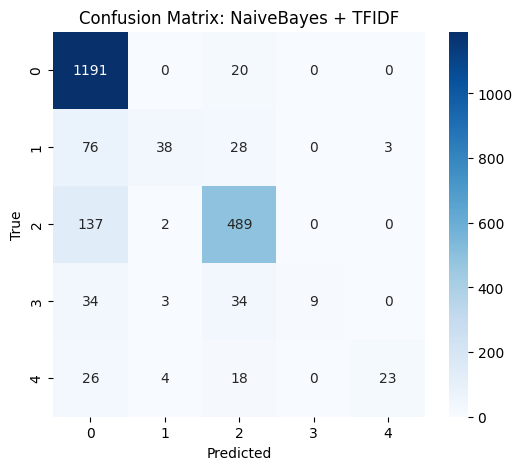

Error training NaiveBayes TFIDF -> [Errno 2] No such file or directory: 'models/NaiveBayes_TFIDF.joblib'


==== FEATURE: Word2Vec ====

>> Model: LogisticRegression

LogisticRegression + Word2Vec | Acc: 0.7995 | Prec(macro): 0.6004 | Rec(macro): 0.7154 | F1(macro): 0.6348
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1211
           1       0.52      0.71      0.60       145
           2       0.80      0.67      0.73       628
           3       0.43      0.62      0.51        80
           4       0.29      0.68      0.41        71

    accuracy                           0.80      2135
   macro avg       0.60      0.72      0.63      2135
weighted avg       0.84      0.80      0.81      2135



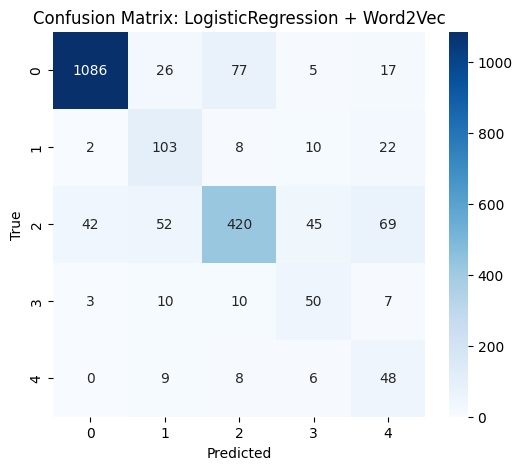

Error training LogisticRegression Word2Vec -> [Errno 2] No such file or directory: 'models/LogisticRegression_Word2Vec.joblib'

>> Model: SVM

SVM + Word2Vec | Acc: 0.8834 | Prec(macro): 0.7265 | Rec(macro): 0.7667 | F1(macro): 0.7428
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1211
           1       0.65      0.71      0.68       145
           2       0.89      0.82      0.85       628
           3       0.65      0.66      0.66        80
           4       0.48      0.68      0.56        71

    accuracy                           0.88      2135
   macro avg       0.73      0.77      0.74      2135
weighted avg       0.89      0.88      0.89      2135



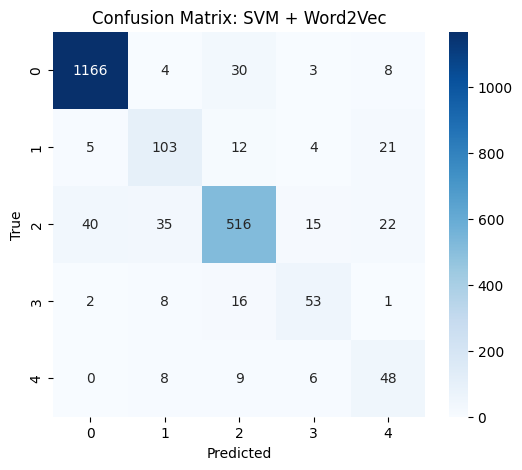

Error training SVM Word2Vec -> [Errno 2] No such file or directory: 'models/SVM_Word2Vec.joblib'

>> Model: RandomForest

RandomForest + Word2Vec | Acc: 0.8412 | Prec(macro): 0.8528 | Rec(macro): 0.6549 | F1(macro): 0.7237
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      1211
           1       0.80      0.57      0.66       145
           2       0.80      0.77      0.79       628
           3       0.97      0.45      0.62        80
           4       0.83      0.54      0.65        71

    accuracy                           0.84      2135
   macro avg       0.85      0.65      0.72      2135
weighted avg       0.84      0.84      0.83      2135



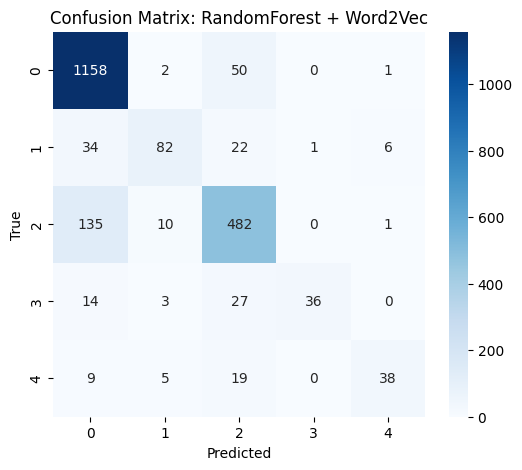

Error training RandomForest Word2Vec -> [Errno 2] No such file or directory: 'models/RandomForest_Word2Vec.joblib'

>> Model: DecisionTree

DecisionTree + Word2Vec | Acc: 0.7400 | Prec(macro): 0.5681 | Rec(macro): 0.5884 | F1(macro): 0.5772
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1211
           1       0.49      0.49      0.49       145
           2       0.68      0.64      0.66       628
           3       0.40      0.46      0.43        80
           4       0.42      0.49      0.45        71

    accuracy                           0.74      2135
   macro avg       0.57      0.59      0.58      2135
weighted avg       0.74      0.74      0.74      2135



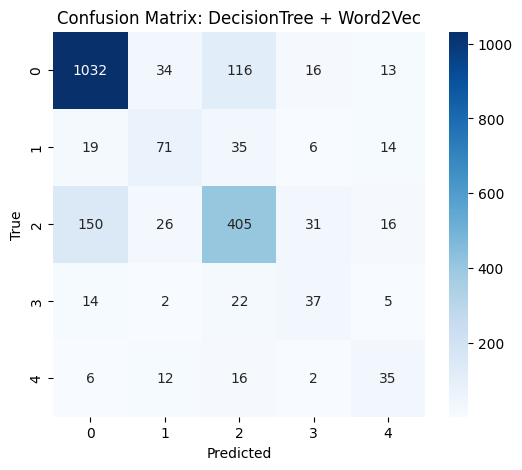

Error training DecisionTree Word2Vec -> [Errno 2] No such file or directory: 'models/DecisionTree_Word2Vec.joblib'

>> Model: GradientBoosting

GradientBoosting + Word2Vec | Acc: 0.8375 | Prec(macro): 0.7895 | Rec(macro): 0.5913 | F1(macro): 0.6515
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1211
           1       0.70      0.48      0.57       145
           2       0.76      0.82      0.78       628
           3       0.91      0.38      0.53        80
           4       0.69      0.34      0.45        71

    accuracy                           0.84      2135
   macro avg       0.79      0.59      0.65      2135
weighted avg       0.83      0.84      0.83      2135



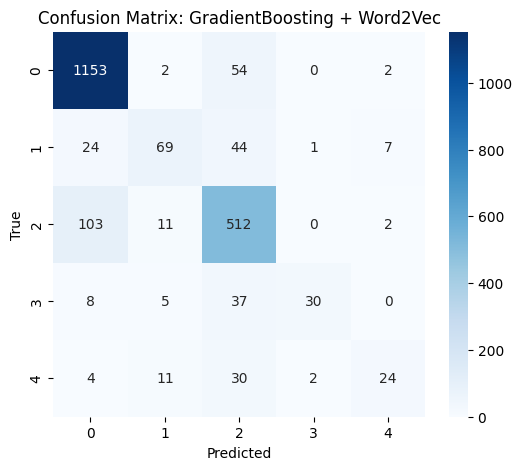

Error training GradientBoosting Word2Vec -> [Errno 2] No such file or directory: 'models/GradientBoosting_Word2Vec.joblib'

>> Model: NaiveBayes
Error training NaiveBayes Word2Vec -> Negative values in data passed to MultinomialNB (input X).


==== FEATURE: FastText ====

>> Model: LogisticRegression

LogisticRegression + FastText | Acc: 0.6810 | Prec(macro): 0.4911 | Rec(macro): 0.6018 | F1(macro): 0.5156
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1211
           1       0.42      0.59      0.49       145
           2       0.73      0.62      0.67       628
           3       0.23      0.46      0.31        80
           4       0.21      0.59      0.31        71

    accuracy                           0.68      2135
   macro avg       0.49      0.60      0.52      2135
weighted avg       0.75      0.68      0.71      2135



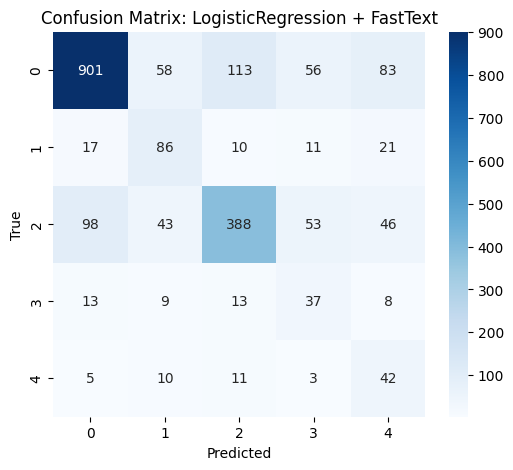

Error training LogisticRegression FastText -> [Errno 2] No such file or directory: 'models/LogisticRegression_FastText.joblib'

>> Model: SVM

SVM + FastText | Acc: 0.7967 | Prec(macro): 0.6614 | Rec(macro): 0.6450 | F1(macro): 0.6440
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1211
           1       0.61      0.61      0.61       145
           2       0.79      0.71      0.75       628
           3       0.70      0.46      0.56        80
           4       0.35      0.54      0.42        71

    accuracy                           0.80      2135
   macro avg       0.66      0.64      0.64      2135
weighted avg       0.80      0.80      0.80      2135



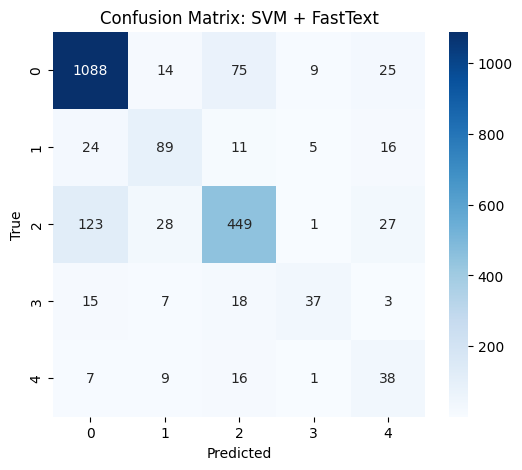

Error training SVM FastText -> [Errno 2] No such file or directory: 'models/SVM_FastText.joblib'

>> Model: RandomForest

RandomForest + FastText | Acc: 0.8005 | Prec(macro): 0.8207 | Rec(macro): 0.5882 | F1(macro): 0.6604
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1211
           1       0.80      0.48      0.60       145
           2       0.78      0.71      0.74       628
           3       0.97      0.36      0.53        80
           4       0.74      0.45      0.56        71

    accuracy                           0.80      2135
   macro avg       0.82      0.59      0.66      2135
weighted avg       0.80      0.80      0.79      2135



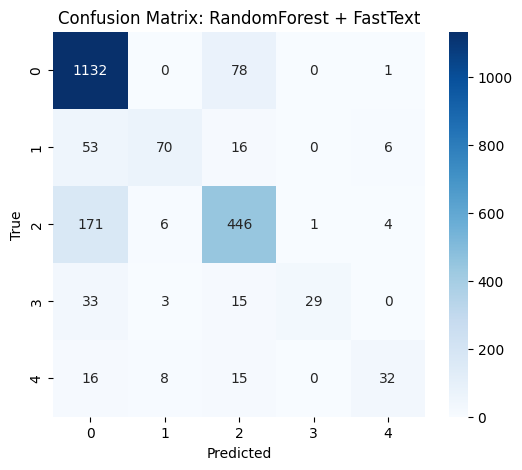

Error training RandomForest FastText -> [Errno 2] No such file or directory: 'models/RandomForest_FastText.joblib'

>> Model: DecisionTree

DecisionTree + FastText | Acc: 0.6768 | Prec(macro): 0.5089 | Rec(macro): 0.5306 | F1(macro): 0.5183
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1211
           1       0.42      0.47      0.44       145
           2       0.64      0.61      0.62       628
           3       0.34      0.42      0.38        80
           4       0.37      0.38      0.38        71

    accuracy                           0.68      2135
   macro avg       0.51      0.53      0.52      2135
weighted avg       0.68      0.68      0.68      2135



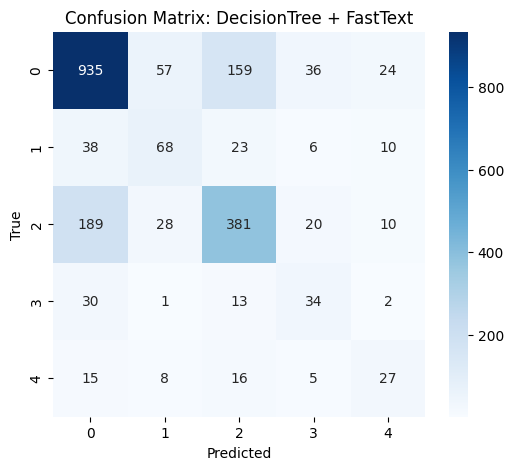

Error training DecisionTree FastText -> [Errno 2] No such file or directory: 'models/DecisionTree_FastText.joblib'

>> Model: GradientBoosting

GradientBoosting + FastText | Acc: 0.7607 | Prec(macro): 0.7364 | Rec(macro): 0.5060 | F1(macro): 0.5643
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1211
           1       0.70      0.37      0.49       145
           2       0.72      0.69      0.71       628
           3       0.85      0.21      0.34        80
           4       0.62      0.35      0.45        71

    accuracy                           0.76      2135
   macro avg       0.74      0.51      0.56      2135
weighted avg       0.76      0.76      0.74      2135



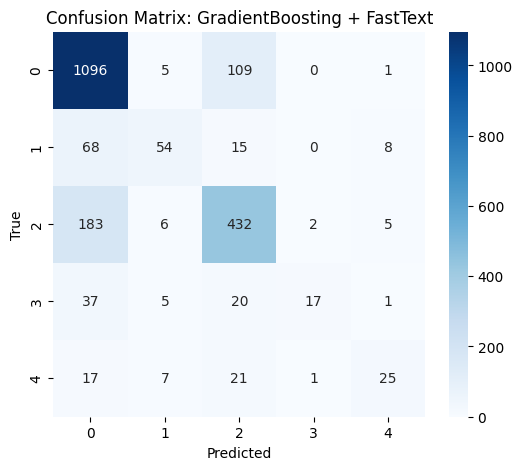

Error training GradientBoosting FastText -> [Errno 2] No such file or directory: 'models/GradientBoosting_FastText.joblib'

>> Model: NaiveBayes
Error training NaiveBayes FastText -> Negative values in data passed to MultinomialNB (input X).


==== FEATURE: Emoji2Vec ====

>> Model: LogisticRegression

LogisticRegression + Emoji2Vec | Acc: 0.7630 | Prec(macro): 0.6536 | Rec(macro): 0.6860 | F1(macro): 0.6629
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1211
           1       0.55      0.78      0.65       145
           2       0.61      0.75      0.67       628
           3       0.66      0.61      0.64        80
           4       0.49      0.49      0.49        71

    accuracy                           0.76      2135
   macro avg       0.65      0.69      0.66      2135
weighted avg       0.80      0.76      0.77      2135



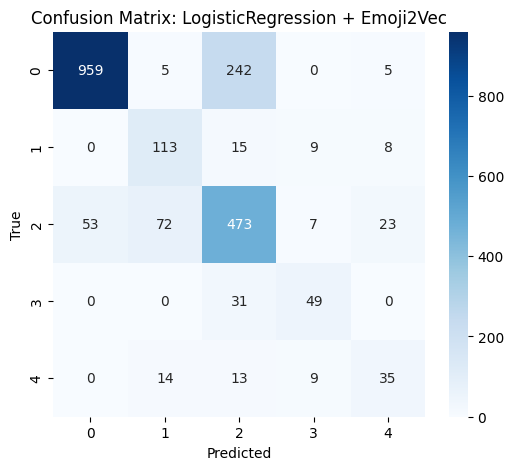

Error training LogisticRegression Emoji2Vec -> [Errno 2] No such file or directory: 'models/LogisticRegression_Emoji2Vec.joblib'

>> Model: SVM

SVM + Emoji2Vec | Acc: 0.7644 | Prec(macro): 0.6549 | Rec(macro): 0.6803 | F1(macro): 0.6619
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1211
           1       0.56      0.74      0.64       145
           2       0.61      0.76      0.68       628
           3       0.66      0.61      0.64        80
           4       0.49      0.49      0.49        71

    accuracy                           0.76      2135
   macro avg       0.65      0.68      0.66      2135
weighted avg       0.80      0.76      0.77      2135



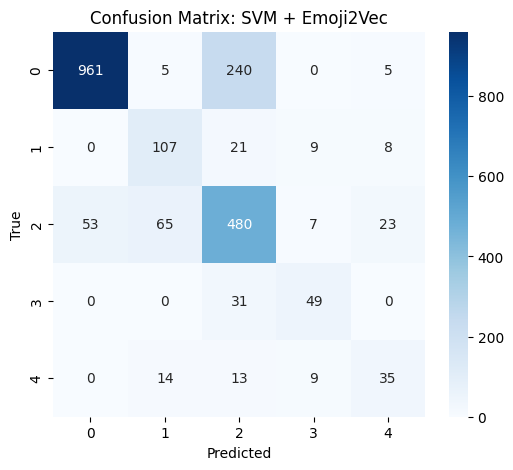

Error training SVM Emoji2Vec -> [Errno 2] No such file or directory: 'models/SVM_Emoji2Vec.joblib'

>> Model: RandomForest

RandomForest + Emoji2Vec | Acc: 0.6810 | Prec(macro): 0.6210 | Rec(macro): 0.6976 | F1(macro): 0.5675
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1211
           1       0.55      0.78      0.65       145
           2       0.97      0.42      0.59       628
           3       0.14      1.00      0.25        80
           4       0.49      0.49      0.49        71

    accuracy                           0.68      2135
   macro avg       0.62      0.70      0.57      2135
weighted avg       0.88      0.68      0.73      2135



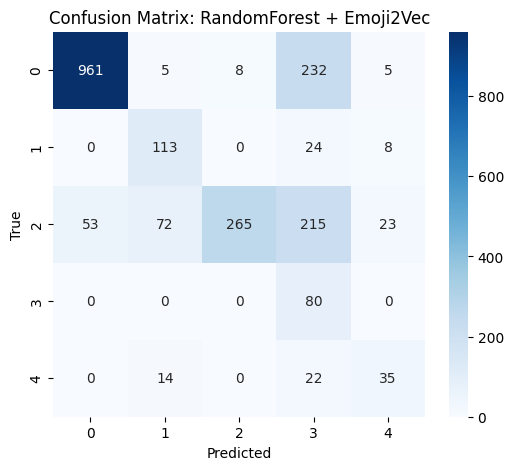

Error training RandomForest Emoji2Vec -> [Errno 2] No such file or directory: 'models/RandomForest_Emoji2Vec.joblib'

>> Model: DecisionTree

DecisionTree + Emoji2Vec | Acc: 0.6810 | Prec(macro): 0.6210 | Rec(macro): 0.6976 | F1(macro): 0.5675
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1211
           1       0.55      0.78      0.65       145
           2       0.97      0.42      0.59       628
           3       0.14      1.00      0.25        80
           4       0.49      0.49      0.49        71

    accuracy                           0.68      2135
   macro avg       0.62      0.70      0.57      2135
weighted avg       0.88      0.68      0.73      2135



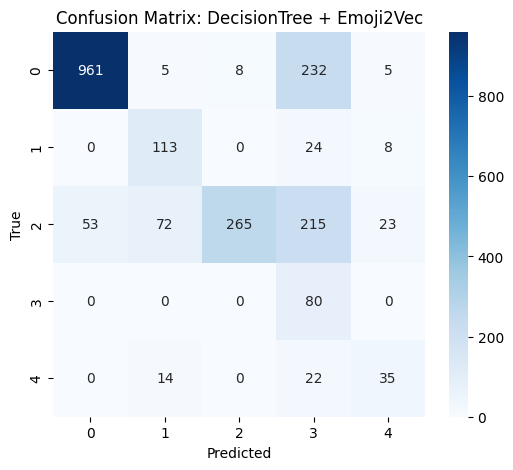

Error training DecisionTree Emoji2Vec -> [Errno 2] No such file or directory: 'models/DecisionTree_Emoji2Vec.joblib'

>> Model: GradientBoosting

GradientBoosting + Emoji2Vec | Acc: 0.7663 | Prec(macro): 0.6751 | Rec(macro): 0.6419 | F1(macro): 0.6514
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1211
           1       0.62      0.52      0.57       145
           2       0.60      0.83      0.70       628
           3       0.66      0.61      0.64        80
           4       0.54      0.45      0.49        71

    accuracy                           0.77      2135
   macro avg       0.68      0.64      0.65      2135
weighted avg       0.80      0.77      0.77      2135



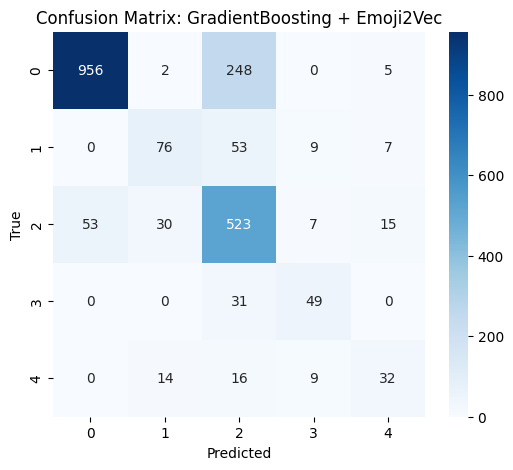

Error training GradientBoosting Emoji2Vec -> [Errno 2] No such file or directory: 'models/GradientBoosting_Emoji2Vec.joblib'

>> Model: NaiveBayes

NaiveBayes + Emoji2Vec | Acc: 0.7803 | Prec(macro): 0.7648 | Rec(macro): 0.5845 | F1(macro): 0.6375
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1211
           1       0.70      0.46      0.55       145
           2       0.78      0.53      0.63       628
           3       0.66      0.61      0.64        80
           4       0.89      0.34      0.49        71

    accuracy                           0.78      2135
   macro avg       0.76      0.58      0.64      2135
weighted avg       0.78      0.78      0.76      2135



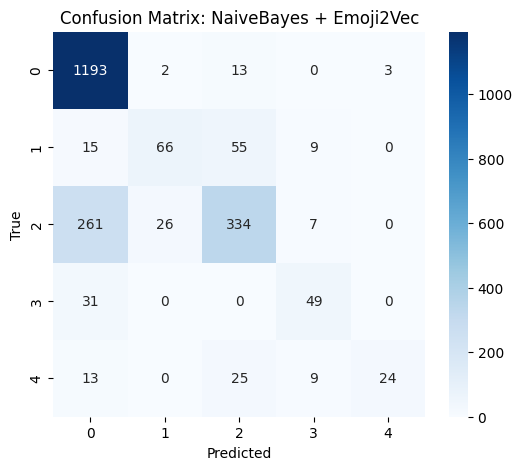

Error training NaiveBayes Emoji2Vec -> [Errno 2] No such file or directory: 'models/NaiveBayes_Emoji2Vec.joblib'


==== FEATURE: BERT ====

>> Model: LogisticRegression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression + BERT | Acc: 0.7855 | Prec(macro): 0.6036 | Rec(macro): 0.7537 | F1(macro): 0.6491
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1211
           1       0.45      0.72      0.55       145
           2       0.85      0.74      0.79       628
           3       0.39      0.81      0.53        80
           4       0.39      0.68      0.50        71

    accuracy                           0.79      2135
   macro avg       0.60      0.75      0.65      2135
weighted avg       0.84      0.79      0.80      2135



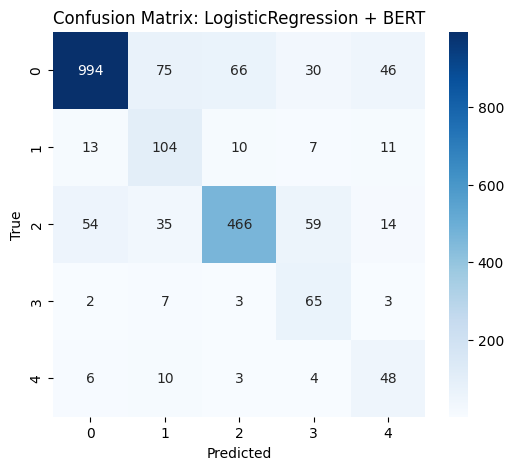

Error training LogisticRegression BERT -> [Errno 2] No such file or directory: 'models/LogisticRegression_BERT.joblib'

>> Model: SVM

SVM + BERT | Acc: 0.8773 | Prec(macro): 0.7659 | Rec(macro): 0.7857 | F1(macro): 0.7750
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1211
           1       0.67      0.67      0.67       145
           2       0.90      0.85      0.87       628
           3       0.71      0.80      0.75        80
           4       0.63      0.68      0.65        71

    accuracy                           0.88      2135
   macro avg       0.77      0.79      0.77      2135
weighted avg       0.88      0.88      0.88      2135



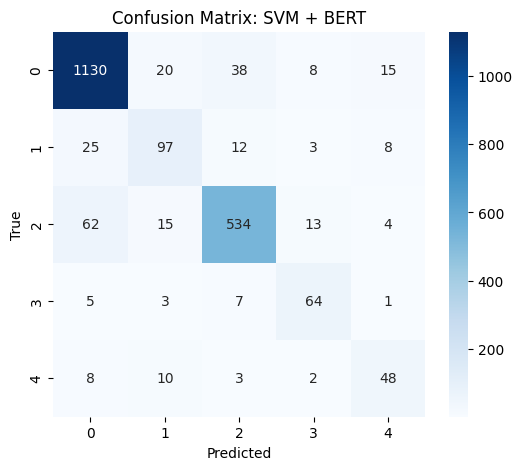

Error training SVM BERT -> [Errno 2] No such file or directory: 'models/SVM_BERT.joblib'

>> Model: RandomForest

RandomForest + BERT | Acc: 0.7593 | Prec(macro): 0.8951 | Rec(macro): 0.4429 | F1(macro): 0.5148
              precision    recall  f1-score   support

           0       0.73      0.98      0.83      1211
           1       1.00      0.16      0.27       145
           2       0.85      0.60      0.71       628
           3       1.00      0.24      0.38        80
           4       0.89      0.24      0.38        71

    accuracy                           0.76      2135
   macro avg       0.90      0.44      0.51      2135
weighted avg       0.80      0.76      0.73      2135



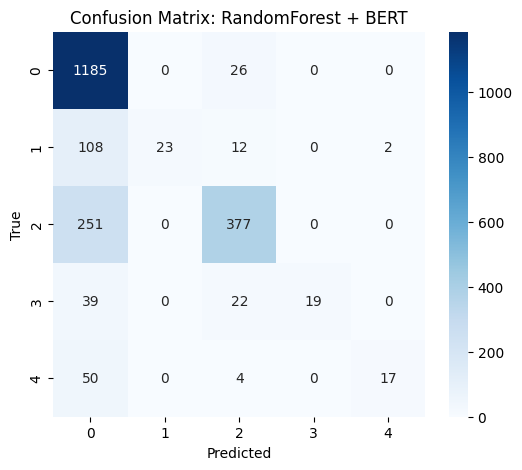

Error training RandomForest BERT -> [Errno 2] No such file or directory: 'models/RandomForest_BERT.joblib'

>> Model: DecisionTree

DecisionTree + BERT | Acc: 0.5991 | Prec(macro): 0.4381 | Rec(macro): 0.4490 | F1(macro): 0.4431
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1211
           1       0.32      0.34      0.33       145
           2       0.53      0.51      0.52       628
           3       0.30      0.35      0.32        80
           4       0.33      0.34      0.34        71

    accuracy                           0.60      2135
   macro avg       0.44      0.45      0.44      2135
weighted avg       0.60      0.60      0.60      2135



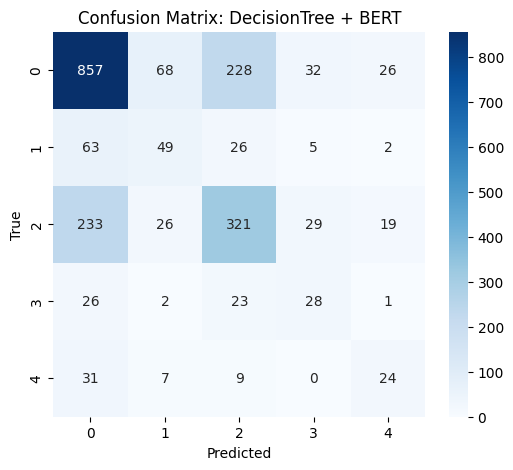

Error training DecisionTree BERT -> [Errno 2] No such file or directory: 'models/DecisionTree_BERT.joblib'

>> Model: GradientBoosting


In [ ]:
# Prepare feature matrix dictionary for convenience
features = {
    "TFIDF": (X_train_tfidf, X_test_tfidf),
    "Word2Vec": (X_train_w2v, X_test_w2v),
    "FastText": (X_train_ft, X_test_ft),
    "Emoji2Vec": (X_train_emoji_tf, X_test_emoji_tf),
    "BERT": (X_train_bert, X_test_bert)
}

ml_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM": LinearSVC(class_weight='balanced', max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced'),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced'),
    "GradientBoosting": GradientBoostingClassifier(),
    "NaiveBayes": MultinomialNB()
}

results = []
os.makedirs("conf_matrices", exist_ok=True)

for feat_name, (Xtr, Xte) in features.items():
    print("\n\n==== FEATURE:", feat_name, "====")
    # If sparse (TF-IDF, emoji TF), OK; if dense numpy, it's fine too.
    for model_name, model in ml_models.items():
        print("\n>> Model:", model_name)
        # Some models (MultinomialNB) need non-negative inputs; ensure TFIDF or emoji features used for NB
        try:
            model_instance = model
            model_instance.fit(Xtr, y_train)
            y_pred = model_instance.predict(Xte)
            r = eval_and_report(f"{model_name} + {feat_name}", y_test, y_pred, output_prefix=f"conf_matrices/{model_name}_{feat_name}")
            r.update({"model": model_name, "feature": feat_name})
            results.append(r)
            # Save model file
            joblib.dump(model_instance, f"models/{model_name}_{feat_name}.joblib")
        except Exception as e:
            print("Error training", model_name, feat_name, "->", e)
        gc.collect()

# Save results DataFrame
os.makedirs("models", exist_ok=True)
results_df = pd.DataFrame(results)
results_df.to_csv("ml_results_summary.csv", index=False)
results_df.sort_values("f1_macro", ascending=False).head(20)


In [ ]:
# Tokenize everything
MAX_WORDS = 20000
MAX_LEN = 80
tk = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tk.fit_on_texts(X)  # fit on whole corpus
vocab_size = min(MAX_WORDS, len(tk.word_index)+1)
print("Vocab size:", vocab_size)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Prepare embedding matrices for Word2Vec / FastText
def build_embedding_matrix(model, token_index, dim):
    emb_matrix = np.zeros((vocab_size, dim))
    for word, i in token_index.items():
        if i>=vocab_size: continue
        if word in model.wv:
            emb_matrix[i] = model.wv[word]
        else:
            emb_matrix[i] = np.random.normal(scale=0.6, size=(dim,))
    return emb_matrix

w2v_emb_matrix = build_embedding_matrix(w2v, tk.word_index, wv_dim)
ft_emb_matrix  = build_embedding_matrix(ft, tk.word_index, ft_dim)

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat  = to_categorical(y_test, num_classes=num_classes)


NameError: name 'Tokenizer' is not defined

In [ ]:
def make_dl_model(model_type, embedding_matrix=None, trainable_emb=False, input_len=MAX_LEN, emb_dim=100, num_classes=num_classes):
    model = Sequential()
    if embedding_matrix is not None:
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1],
                            input_length=input_len, weights=[embedding_matrix], trainable=trainable_emb))
    else:
        model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=input_len))
    if model_type == "CNN":
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
    elif model_type == "RNN":
        model.add(SimpleRNN(128))
    elif model_type == "LSTM":
        model.add(LSTM(128))
    elif model_type == "BiLSTM":
        model.add(Bidirectional(LSTM(128)))
    elif model_type == "GRU":
        model.add(GRU(128))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

dl_models = ["CNN", "RNN", "LSTM", "BiLSTM", "GRU"]
emb_configs = {
    "W2V": w2v_emb_matrix,
    "FT": ft_emb_matrix,
    "RAND": None
}

dl_results = []

for emb_name, emb_matrix in emb_configs.items():
    for mtype in dl_models:
        print("\n=== DL:", mtype, "with", emb_name, "embeddings ===")
        model = make_dl_model(mtype, embedding_matrix=emb_matrix, trainable_emb=False, emb_dim=100)
        es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        ckpt_path = f"models/dl_{mtype}_{emb_name}.h5"
        mc = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)
        history = model.fit(X_train_pad, y_train_cat, validation_split=0.1, epochs=8, batch_size=64, callbacks=[es, mc], verbose=2)
        preds_proba = model.predict(X_test_pad)
        preds = preds_proba.argmax(axis=1)
        metrics = eval_and_report(f"{mtype} + {emb_name}", y_test, preds, output_prefix=f"conf_matrices/{mtype}_{emb_name}")
        metrics.update({"model": mtype, "feature": emb_name})
        dl_results.append(metrics)
        # Save Keras model
        model.save(ckpt_path)
        gc.collect()


NameError: name 'num_classes' is not defined

In [ ]:
# Simple Logistic Regression on BERT embeddings
print("Training LogisticRegression on BERT features")
clf_bert = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_bert.fit(X_train_bert, y_train)
y_pred_bert = clf_bert.predict(X_test_bert)
bert_metrics = eval_and_report("LogReg + BERT", y_test, y_pred_bert, output_prefix="conf_matrices/LogReg_BERT")
bert_metrics.update({"model":"LogisticRegression","feature":"BERT"})


Training LogisticRegression on BERT features


NameError: name 'LogisticRegression' is not defined

In [ ]:
# ML results already saved in results_df earlier
ml_df = pd.read_csv("ml_results_summary.csv")
dl_df = pd.DataFrame(dl_results)
all_results = pd.concat([ml_df, dl_df, pd.DataFrame([bert_metrics])], ignore_index=True, sort=False)
all_results = all_results[['model','feature','accuracy','precision_macro','recall_macro','f1_macro']].sort_values('f1_macro', ascending=False)
all_results.to_csv("all_models_results_summary.csv", index=False)
all_results.head(30)

NameError: name 'pd' is not defined

In [ ]:
best = all_results.iloc[0]
print("Best model:", best.to_dict())
best_model_name = best['model']
best_feature = best['feature']
print("Best combination:", best_model_name, best_feature)